# Machine Learning on Parking Space Occupation in Dresden

Can we predict the occupation of a parking space in Dresden with just a time?

Read about it here: http://mechlab-engineering.de/2015/03/vorhersage-der-parkhausbelegung-mit-offenen-daten/

In [1]:
import pandas as pd
import numpy as np
import requests
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates

#import seaborn as sns
#sns.set_style('whitegrid')
#sns.set_context('talk')

[Here is a map for the parking spaces in Dresden](http://ubahn.draco.uberspace.de/opendata/ui/) and the guys from the Open Knowledge Foundation Dresden (Offenes Dresden) stored the data in a DB and provide a dump of the data.

You can download it with:

`wget http://ubahn.draco.uberspace.de/opendata/dump/parken_dump.csv`


In [2]:
data = pd.read_csv('parken_dump.csv', encoding='latin1')

Calc the occupation ([ger] Belegung)

In [3]:
data['Belegung'] = 100.0-data['free']/data['count']*100.0

Pivot the data

In [4]:
ppDD = data.pivot(index='time', columns='name', values='Belegung')

In [5]:
# Define index and names
ppDD.index = pd.DatetimeIndex(ppDD.index)
ppDD.index.name = 'Zeit'
ppDD.columns.name = 'Parkplatz'

print('Daten von %s/%s bis %s/%s' % (ppDD.index[0].month, ppDD.index[0].year, ppDD.index[-1].month, ppDD.index[-1].year)) 

Daten von 4/2014 bis 3/2015


In [6]:
# format the percent without digits
ppDD = ppDD.applymap(lambda x: float('%.0f' % x))

# and limit it between 0...100%
ppDD = ppDD.applymap(lambda x: min(max(x, 0.0), 100.0))

In [7]:
ppDD.tail(3)

Parkplatz,Altmarkt,Altmarkt - Galerie,An der Frauenkirche,Bühlau,Centrum-Galerie,City Center,Cossebaude,Ferdinandplatz,Flutrinne,Frauenkirche Neumarkt,...,Schießgasse,Semperoper,Taschenbergpalais,Terrassenufer,Terrassenufer Bus,Theresienstraße,Wiener Platz/Hbf.,Wiesentorstraße,World Trade Center,Wöhrl - Florentinum
Zeit,,,,,,,,,,,,,,,,,,,,,
2015-03-25 12:15:05,43,63,47,100,65,56,53,76,NaN,43,...,100,26,48,59,36,63,68,47,37,38
2015-03-25 12:30:05,45,64,48,100,66,56,53,73,NaN,44,...,100,26,47,62,41,63,66,48,40,38
2015-03-25 12:45:05,47,62,49,100,67,57,55,70,NaN,46,...,99,26,48,71,45,59,64,48,39,36


# Predict for the Centrum-Galerie Dresden

In [8]:
centrumGalerie = ppDD[['Centrum-Galerie']].dropna()

Ok, take a look at the TimeSeries

In [9]:
# function to plot timeseries with weekend
def plotbelegung(df, which, fromdate, todate):
    weekend = df[fromdate:todate].index[df[fromdate:todate].index.weekday>4]
    ax = df[fromdate:todate][which].plot(figsize=(9,6), ylim=(0, 130), alpha=0.9, rot=0, title='Auslastung Parkhaus Centrum Galerie Dresden %s bis %s' % (fromdate, todate))
    
    if not df.index.freqstr: # Wenn DataFrame keine Frequenz hat
        ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0,1,2,3,4,5,6),interval=2))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d.'))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\nSa/So'))
        ax.xaxis.grid(True, which="minor")
        ax.xaxis.grid(False, which="major")
    
    plt.ylabel('%')
    
    for w in weekend[::10]:
        plt.axvline(w, c='k', alpha=0.08, zorder=-1)
        
    return plt

<module 'matplotlib.pyplot' from '/Users/paul/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

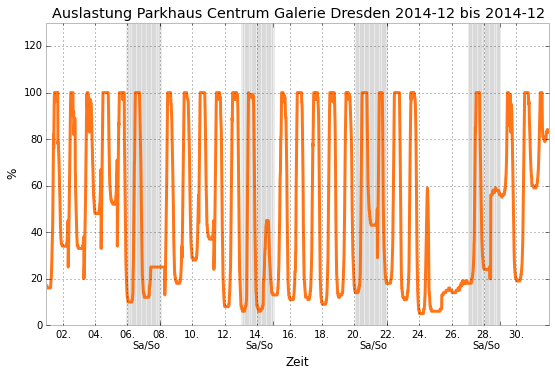

In [10]:
plotbelegung(centrumGalerie, 'Centrum-Galerie', '2014-12', '2014-12')

# Let's do some Machine Learning on that

## Labels

Labels sind die Belegung des Parkhauses (wenn in 10% Schritten steigt die Model Accuracy auf über 85%)

In [11]:
centrumGalerie['Belegung'] = centrumGalerie['Centrum-Galerie']#.apply(lambda x: round(x/10.0)*10.0)

Ich stelle mir vor, dass folgende Faktoren Einfluss auf die Belegung der Parkplätze haben (in dieser Reihenfolge):

## Features

* Uhrzeit
* Wochentag
* Kalenderwoche
* Verkaufsoffener Sonntag
* nächster Tag Feiertag? (Deutschland)
* übernächster Tag auch noch Feiertag? (Deutschland)
* Ferien (Deutschland)
* spezielles Event in Galerien oder Stadt oder Kultur
* nächster Tag Feiertag? (Tschechien)
* übernächster Tag auch noch Feiertag? (Tschechien)
* Ferien (Tschechien)
* Wetter

Wir haben nicht alle Features. Aber wenigstens die wichtigsten.

### Wochentag

Es ist wichtig, ob Montag oder Samstag oder Sonntag ist.

In [12]:
centrumGalerie['Wochentag'] = centrumGalerie.index.dayofweek

### Kalenderwoche

Es ist wichtig, ob z.B. Dezember ist (Weihnachten) oder dann Flaute im Januar/Februar.

In [13]:
centrumGalerie['Kalenderwoche'] = centrumGalerie.index.week

### Uhrzeit

Dann ist es natürlich extrem wichtig, ob es in der Nacht ist oder tagsüber.

In [14]:
centrumGalerie['Minuten'] = centrumGalerie.index.hour * 60.0 + centrumGalerie.index.minute

### Verkaufsoffener Sonntag

Waren in Dresden: 13. April 2014, 5. Oktober 2014, 7. Dezember 2014, 21. Dezember 2014

In [15]:
offeneSonntage = pd.to_datetime(['2014-04-13','2014-10-05','2014-12-07','2014-12-21'])

In [16]:
def isoffenersonntag(serie):
    for tag in range(len(offeneSonntage)):
        if serie.date() == offeneSonntage[tag].date():
            return 1
        else:
            return 0

In [17]:
sonntagsseries = pd.Series(centrumGalerie.index, name='offeneSonntage', index=centrumGalerie.index).apply(isoffenersonntag)
centrumGalerie['offenerSonntag'] = sonntagsseries

### Feiertage

Wenn ein Feiertag naht, dann gehen auch mehr Leute in die Stadt. Deshalb ist das ein Feature.

Get them from http://www.feiertage.net

In [18]:
feiertage = pd.read_csv('Sachsen2014.csv', index_col=0, parse_dates=True, sep=';', dayfirst=True)
feiertage = feiertage.append(pd.read_csv('Sachsen2015.csv', index_col=0, parse_dates=True, sep=';', dayfirst=True))

In [19]:
feiertage

,Feiertage,Bundesland
Tag,,
2014-01-01,Neujahr,Sachsen
2014-04-18,Karfreitag,Sachsen
2014-04-21,Ostermontag,Sachsen
2014-05-01,Maifeiertag,Sachsen
2014-05-29,Christi Himmelfahrt,Sachsen
2014-06-09,Pfingstmontag,Sachsen
2014-06-19,Fronleichnam,Sachsen
2014-10-03,Tag der Deutschen Einheit,Sachsen
2014-10-31,Reformationstag,Sachsen


Mit [numpy.busday_count](http://docs.scipy.org/doc/numpy/reference/generated/numpy.busday_count.html) bekommen wir die Anzahl der Werktage bis zum nächsten Feiertag, weil die Leute ja vor einem langen Wochenende immer noch mal richtig einkaufen gehen.

In [20]:
def shoppingdaystonextfeiertag(df):
    diffs = []
    for feiertag in feiertage.index:
        diff = np.busday_count(df.date(), feiertag.date(), weekmask='Mon Tue Wed Thu Fri Sat')
        #print('%s bis %s: %i Arbeitstage' % (feiertag, df, diff)) 
        diffs.append(diff)
        
    try:
        return min([d for d in diffs if d>=0])
    except:
        return 100 # wenn kein Feiertag gefunden

In [21]:
feiertagseries = pd.Series(centrumGalerie.index, name='Feiertage', index=centrumGalerie.index).apply(shoppingdaystonextfeiertag)
centrumGalerie['bisFeiertag'] = feiertagseries

In [22]:
centrumGalerie.head(5)

Parkplatz,Centrum-Galerie,Belegung,Wochentag,Kalenderwoche,Minuten,offenerSonntag,bisFeiertag
Zeit,,,,,,,
2014-04-13 01:38:23,31,31,6,15,98,1,4
2014-04-13 01:45:04,30,30,6,15,105,1,4
2014-04-13 02:00:05,30,30,6,15,120,1,4
2014-04-13 02:15:05,30,30,6,15,135,1,4
2014-04-13 02:30:04,30,30,6,15,150,1,4


### Featurevector

In [23]:
featurevector = ['Kalenderwoche','Wochentag','Minuten','offenerSonntag','bisFeiertag']

OK, nun haben wir Labels und Features fertig.

Nun können wir Test und Trainingsdatensatz erstellen.

## Train some Machine Learning Classifiers

In [24]:
labels = centrumGalerie['Belegung'].values
np.shape(labels)

(32753,)

In [25]:
features = centrumGalerie[featurevector].values
np.shape(features)

(32753, 5)

In [26]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [27]:
# Import some Models to cycle through
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

### Split into test and training set

To get an accuracy score, we need to split our dataset in a training and a test set. We train with the training set and test the model later with the part of the test set.

In [28]:
trainwith = 0.5 # Learn with 50% of the data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=trainwith, random_state=42)

In [29]:
np.shape(features_test)

(16377, 5)

### Test some models with standard parameter set

In [30]:
for Model in [KNeighborsClassifier, GaussianNB, RandomForestClassifier, DecisionTreeClassifier, DecisionTreeRegressor]:

    modelname = str(Model).split('.')[-1][:-2]
    #print modelname
    
    t0 = time.time()
    
    clf = Model().fit(features_train, labels_train)
    tt = time.time() - t0
    
    labels_predict = clf.predict(features_test)
    tp = time.time() - t0
    
    score = accuracy_score(labels_predict, labels_test)

    print('%.3f Accuracy Score by %s (Timings: %.2fs/%.2fs)' % (score, modelname, tt, tp))

0.057 Accuracy Score by KNeighborsClassifier (Timings: 0.02s/0.21s)
0.083 Accuracy Score by GaussianNB (Timings: 0.02s/0.22s)
0.466 Accuracy Score by RandomForestClassifier (Timings: 0.37s/0.61s)
0.456 Accuracy Score by DecisionTreeClassifier (Timings: 0.09s/0.11s)
0.466 Accuracy Score by DecisionTreeRegressor (Timings: 0.05s/0.05s)


These accuracy scores don't look that amazing, but remember, we try to predict the occupation of a park house by 1% precision. In reality, it doesn't matter if our model predicts 15% and the real value is 16%, but the accuracy score gives a penalty as false prediction. We don't care. :)

### DecisionTreeRegressor looks good and is fast, let's try some parameters

Because it is a regression (output are continuous values) it might fit the data better than a classifier. So we test the the predicted labels with the test labels with the $R^2$ score (coefficient of determination).

In [31]:
print('max_depth\tmin_samples_split\tR2_score (higher is better)')
maxscore = 0.5
for md in range(1, 20):
    for mins in range(1, 10):
        classifier = DecisionTreeRegressor(max_depth=md, min_samples_split=mins).fit(features_train, labels_train)
        labels_predict = classifier.predict(features_test)
        score = r2_score(labels_test, labels_predict)
        if score>maxscore:
            print('%i\t\t\t%i\t\t\t%.3f' % (md, mins, score))
            maxscore=score

max_depth	min_samples_split	R2_score (higher is better)
3			1			0.628
4			1			0.683
5			1			0.733
6			1			0.772
7			1			0.819
7			6			0.819
8			1			0.863
8			4			0.863
9			1			0.896
9			2			0.897
9			4			0.897
10			1			0.929
10			2			0.929
10			3			0.929
10			4			0.929
11			1			0.941
11			2			0.943
11			4			0.944
11			5			0.944
12			1			0.948
12			2			0.950
12			3			0.950
12			4			0.951
13			1			0.957
13			2			0.957
13			3			0.958
14			1			0.963
14			3			0.964
14			4			0.964
15			1			0.966
15			4			0.967
15			5			0.967
16			4			0.968
16			5			0.970
17			1			0.970
17			3			0.971
17			5			0.972
18			1			0.972
18			3			0.972
18			4			0.972
19			3			0.973


A high $R^2$-score is better, but if we have a high `max_depth`, which might overfit the dataset.

## Model

In [32]:
classifier = DecisionTreeRegressor(max_depth=12, min_samples_split=4).fit(features_train, labels_train)

### Overfit test

One can check for overfitting by just test the model with the training features. If the score is very high (and the score with the test features is low), it is likely, that the model is overfitted.

In [33]:
# Let's check if we overfit. If, the accuracy with the training set is very high, with the test set very low.
labels_predict_overfittest = classifier.predict(features_train).astype('int')
score = accuracy_score(labels_train, labels_predict_overfittest)
print('%.3f Accuracy Score with training data' % (score))

if score>0.6:
    print('You probably overfit it!')

0.277 Accuracy Score with training data


### What is the most important feature for the model

In [34]:
importances = classifier.feature_importances_

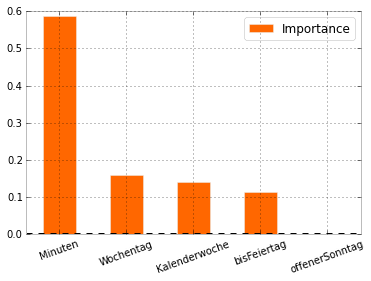

In [35]:
featureimportance = pd.DataFrame(index=featurevector, data=importances, columns=['Importance']).sort('Importance', ascending=False).plot(kind='bar', rot=20)

Obviously it is the time of the day (`Minuten` since midnight), the calender week, the days until the next holiday (because people tend to go shopping if the weekend is long) and for sure the day of the week (because saturday is shopping day!).

In [36]:
labels_predict = classifier.predict(features_test).astype('int')

In [37]:
r2_score(labels_test, labels_predict)

0.94818792153252174

### Let's take a look at the confusion matrix

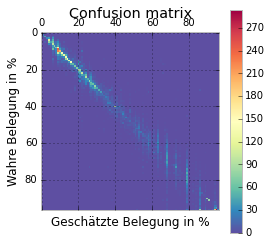

In [38]:
cm = confusion_matrix(labels_test, labels_predict)

plt.matshow(cm, cmap=plt.cm.Spectral_r, interpolation='none')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel(u'Wahre Belegung in %')
plt.xlabel(u'Geschätzte Belegung in %')

As you can see, the confusion matrix looks pretty good. That's not perfect, but take into account, that we just have a few features for such a complex scenario like inner-city parking space occupation.

# Predict

Here we predict it for the whole dataset

In [39]:
def predictBelegung(df):
    features = df[featurevector].values
    prediction = int(classifier.predict([features]))
    return prediction

Fire it on the whole Dataset

In [40]:
centrumGalerie['Vorhersage'] = centrumGalerie.apply(predictBelegung, axis=1)

In [41]:
centrumGalerie.head(5)

Parkplatz,Centrum-Galerie,Belegung,Wochentag,Kalenderwoche,Minuten,offenerSonntag,bisFeiertag,Vorhersage
Zeit,,,,,,,,
2014-04-13 01:38:23,31,31,6,15,98,1,4,30
2014-04-13 01:45:04,30,30,6,15,105,1,4,30
2014-04-13 02:00:05,30,30,6,15,120,1,4,30
2014-04-13 02:15:05,30,30,6,15,135,1,4,30
2014-04-13 02:30:04,30,30,6,15,150,1,4,30


In [42]:
centrumGalerie['Vorhersage'] = pd.rolling_mean(centrumGalerie['Vorhersage'], 8).shift(-4)

<module 'matplotlib.pyplot' from '/Users/paul/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

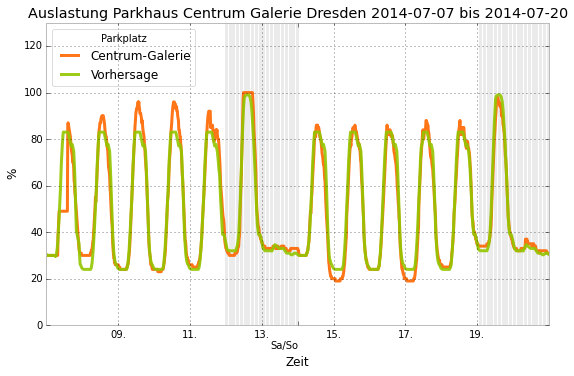

In [43]:
plotbelegung(centrumGalerie, ['Centrum-Galerie','Vorhersage'], '2014-07-07', '2014-07-20')

<module 'matplotlib.pyplot' from '/Users/paul/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

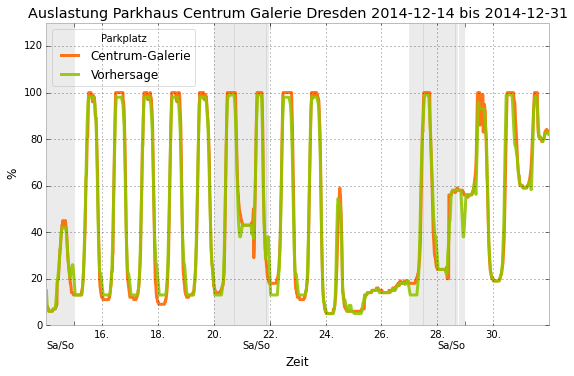

In [44]:
plotbelegung(centrumGalerie, ['Centrum-Galerie','Vorhersage'], '2014-12-14', '2014-12-31')
#plt.savefig('Centrum-Galerie-Belegung-Vorhersage.png', bbox_inches='tight', dpi=150)

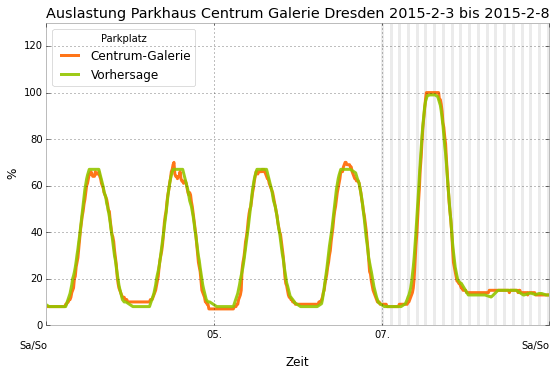

In [45]:
plotbelegung(centrumGalerie, ['Centrum-Galerie','Vorhersage'], '2015-2-3', '2015-2-8')
plt.savefig('Centrum-Galerie-Belegung-Vorhersage.png', bbox_inches='tight', dpi=150)

## Let's test some predictions

In [46]:
featurevector

['Kalenderwoche', 'Wochentag', 'Minuten', 'offenerSonntag', 'bisFeiertag']

Beispiel 1

* Kalenderwoche 3
* Samstag (0=Mo, 1=Di, 2=Mi, 3=Do, 4=Fr, 5=Sa, 6=So)
* 15Uhr (`15*60min` nach 0Uhr)
* kein verkaufsoffener Sonntag
* 5 Tage bis zum nächsten Feiertag

In [47]:
print('%i%% Belegung' % classifier.predict([3, 5, 15*60, 0, 5]))

99% Belegung


Beispiel 2

* Kalenderwoche 50
* Sonntag (0=Mo, 1=Di, 2=Mi, 3=Do, 4=Fr, 5=Sa, 6=So)
* 15Uhr (`15*60min` nach 0Uhr)
* kein verkaufsoffener Sonntag
* 15 Werktage bis zum nächsten Feiertag

In [48]:
print('%i%% Belegung' % classifier.predict([50, 6, 15*60, 0, 15]))

42% Belegung


Beispiel 3

* Kalenderwoche 7
* Mittwoch (0=Mo, 1=Di, 2=Mi, 3=Do, 4=Fr, 5=Sa, 6=So)
* 6Uhr (`15*60min` nach 0Uhr)
* kein verkaufsoffener Sonntag
* 20 Tage bis zum nächsten Feiertag

In [49]:
print('%i%% Belegung' % classifier.predict([7, 2, 6*60, 0, 20]))

29% Belegung


### Let's create a series in the future

In [50]:
future = pd.DataFrame(index=pd.date_range('2015-05-01', '2016-01-01', freq='15Min'))
future['Wochentag'] = future.index.dayofweek
future['Kalenderwoche'] = future.index.week
future['Minuten'] = future.index.hour * 60.0 + future.index.minute
feiertagseries = pd.Series(future.index, name='Feiertage', index=future.index).apply(shoppingdaystonextfeiertag)
future['bisFeiertag'] = feiertagseries
sonntagsseries = pd.Series(future.index, name='offeneSonntage', index=future.index).apply(isoffenersonntag)
future['offenerSonntag'] = sonntagsseries

In [51]:
future['Vorhersage'] = future.apply(predictBelegung, axis=1)

In [52]:
future['Vorhersage'] = pd.rolling_mean(future['Vorhersage'], 8).shift(-4)

In [53]:
future.tail(5)

,Wochentag,Kalenderwoche,Minuten,bisFeiertag,offenerSonntag,Vorhersage
2015-12-31 23:00:00,3,53,1380,100,0,24.5
2015-12-31 23:15:00,3,53,1395,100,0,NaN
2015-12-31 23:30:00,3,53,1410,100,0,NaN
2015-12-31 23:45:00,3,53,1425,100,0,NaN
2016-01-01 00:00:00,4,53,0,100,0,NaN


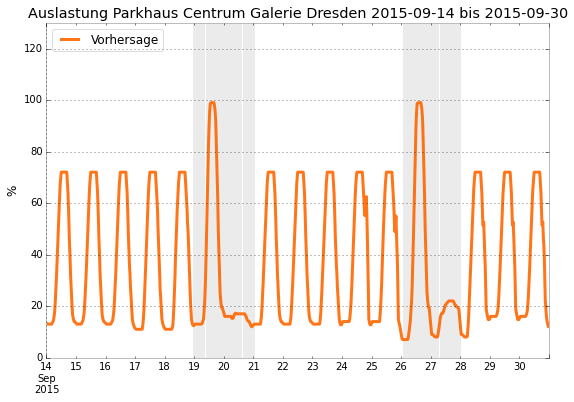

In [54]:
plotbelegung(future, ['Vorhersage'], '2015-09-14', '2015-09-30')
plt.savefig('Centrum-Galerie-Belegung-Vorhersage-2015.png', bbox_inches='tight', dpi=150)

In [55]:
future['Vorhersage'].to_csv('Centrum-Galerie-Belegung-Vorhersage-2015.csv')

## Save the Classifier for later use

Later you can load back the pickled model (possibly in another Python process) with:

`with open('classifier.pkl', 'rb') as fid:
    classifier = pickle.load(fid)`

In [56]:
import pickle
with open('./Classifier/DecisionTreeRegressor-CentrumGalerie.pkl', 'wb') as fid:
    pickle.dump(classifier, fid)  

Questions: [@Balzer82](https://twitter.com/Balzer82)